In [1]:
!pip install adjustText

In [2]:
!pip install ml_metrics

In [3]:
import pandas as pd
import numpy as np
from numpy.random import *
from ml_metrics import quadratic_weighted_kappa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
from adjustText import adjust_text
import matplotlib.pyplot as plt

In [4]:
def eval_wrapper(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    return quadratic_weighted_kappa(yhat, y)

In [5]:
def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

In [6]:
def apply_offsets(data, offsets):
    for j in range(num_classes):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data

In [7]:
# global variables
columns_to_drop = ['Id', 'Response']
missing_indicator = -1000

In [8]:
all_data = pd.read_csv("train.csv")
all_data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [9]:
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

In [10]:
# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

all_data.fillna(missing_indicator, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)
all_data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_char,Product_Info_2_num,BMI_Age,Med_Keywords_Count
0,2,1,0,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,-1000.0000,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,-1000.000000,0.598039,-1000.000000,0.526786,4.0,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0.207304,0
1,5,1,1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,-1000.000000,0.084507,-1000.000000,5.0,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,0.016256,0
2,6,1,2,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,-1000.000000,3,2,3,3,0.304348,-1000.000000,0.225352,-1000.000000,10.0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2,1,0.012799,0
3,7,1,3,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,-1000.000000,3,2,3,3,0.420290,-1000.000000,0.352113,-1000.000000,0.0,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,2,0.057863,1
4,8,1,4,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,-1000.000000,3,2,3,2,0.463768,-1000.000000,0.408451,-1000.000000,-1000.0,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,3,0.177213,0


In [11]:
train, test = train_test_split(all_data, test_size = 0.1, random_state = 752)
print(train.shape)
print(test.shape)

(53442, 132)
(5939, 132)


In [12]:
#Predictor and responce variables
train_x = train.drop(['Id', 'Response'], axis = 1)
train_y = train['Response']
test_x = test.drop(['Id', 'Response'], axis = 1)
test_y = test['Response']
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(53442, 130)
(53442,)
(5939, 130)
(5939,)


In [13]:
#Function for normalization
def normalization(data):
    return (data - data.min())/(data.max() - data.min())

In [14]:
#Train and test data shapes
print(train_x.shape)
print(test_x.shape)

(53442, 130)
(5939, 130)


In [15]:
#Model for the Random Forest Classifier
model = RandomForestClassifier(n_estimators=50, max_features=75, max_depth=50, 
                               min_samples_leaf=8, min_samples_split=40,
                               bootstrap = False)

model.fit(train_x, train_y)

test_pred = model.predict(test_x) 
train_pred = model.predict(train_x)

print("Classification score for testing set: ", classification_report(test_y, test_pred))

Classification score for SOAM1:               precision    recall  f1-score   support

           1       0.45      0.18      0.26       600
           2       0.47      0.21      0.29       652
           3       0.58      0.43      0.49        91
           4       0.62      0.73      0.67       138
           5       0.63      0.57      0.60       530
           6       0.53      0.54      0.54      1120
           7       0.46      0.45      0.46       819
           8       0.67      0.92      0.77      1989

    accuracy                           0.59      5939
   macro avg       0.55      0.50      0.51      5939
weighted avg       0.56      0.59      0.56      5939



In [16]:
print("Classification score for training set: ", classification_report(train_y, train_pred))

Classification score for SOAM (train):                precision    recall  f1-score   support

           1       0.82      0.38      0.52      5607
           2       0.77      0.39      0.52      5900
           3       0.73      0.48      0.58       922
           4       0.68      0.76      0.72      1290
           5       0.72      0.63      0.67      4902
           6       0.67      0.74      0.71     10113
           7       0.67      0.66      0.66      7208
           8       0.72      0.95      0.82     17500

    accuracy                           0.71     53442
   macro avg       0.72      0.62      0.65     53442
weighted avg       0.72      0.71      0.69     53442



In [17]:
#Accuracy-training set
print(accuracy_score(train_y, train_pred))
print(f1_score(train_y, train_pred, average = 'weighted'))
print(precision_score(train_y, train_pred, average = 'weighted'))
print(recall_score(train_y, train_pred, average = 'weighted'))

0.7085438419220838
0.6914359225489336
0.7181920923147777
0.7085438419220838


In [18]:
#Accuracy-testing set
print(accuracy_score(test_y, test_pred))
print(f1_score(test_y, test_pred, average = 'weighted'))
print(precision_score(test_y, test_pred, average = 'weighted'))
print(recall_score(test_y, test_pred, average = 'weighted'))

0.588651288095639
0.5577082461331493
0.5631576517210796
0.588651288095639


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


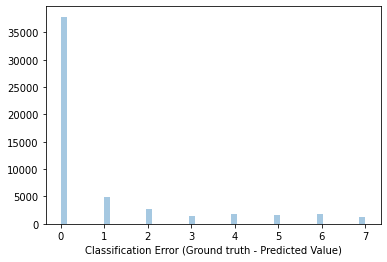

In [19]:
#DistPlot - Train
sns.distplot(abs(np.array(train_y)-train_pred), kde=False, axlabel='Classification Error (Ground truth - Predicted Value)')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


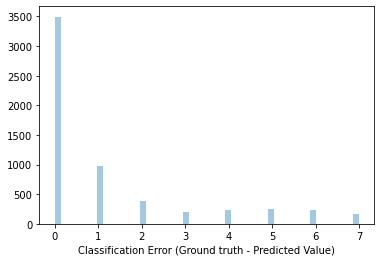

In [20]:
#DistPlot - Test
sns.distplot(abs(test_y-test_pred), kde=False, axlabel='Classification Error (Ground truth - Predicted Value)')

In [21]:
# RMSE
print(np.sqrt(mean_squared_error(test_y, test_pred)))
print(np.sqrt(mean_squared_error(train_y, train_pred)))

2.270516459032874
2.0233702502611464


In [23]:
# MAE
print(mean_absolute_error(test_y, test_pred))
print(mean_absolute_error(train_y, train_pred))

1.1895942077790873
0.9149171063957188


In [24]:
#Quadratic Weighted Kappa
print(eval_wrapper(train_pred, train_y))
print(eval_wrapper(test_pred, test_y))

0.6184416173507171
0.5078827920933984


In [25]:
rmse = [2.031708524115556, 2.263981089169368]
mae = [0.9225702630889563, 1.1885839366896784]
acc = [0.7069159088357472, 0.5861256103721165]
qwk = [0.6144943279531684, 0.5027416257338551]

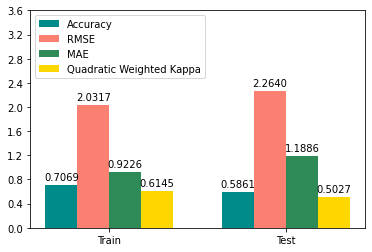

In [26]:
index = np.arange(2)
sets = ['Train','Test']
bar_width = 0.18
score_label = np.arange(0, 4, 0.4)
fig, ax = plt.subplots()
barAcc = ax.bar(index - 1.5*bar_width, acc, bar_width, label = 'Accuracy', color = 'darkcyan')
barRMSE = ax.bar(index - 0.5*bar_width, rmse, bar_width, label = 'RMSE', color = 'salmon')
barMAE = ax.bar(index + 0.5*bar_width, mae, bar_width, label = 'MAE', color = 'seagreen')
barQWK = ax.bar(index + 1.5*bar_width, qwk, bar_width, label = 'Quadratic Weighted Kappa', color = 'gold')
ax.set_xticks(index)
ax.set_xticklabels(sets)
ax.set_yticks(score_label)
ax.legend(loc="upper left")

def insert_data_labels(bars):
    for bar in bars:
        bar_height=bar.get_height()
        ax.annotate('{:.4f}'.format(bar.get_height()), 
                    xy=(bar.get_x() + bar.get_width()/2, bar_height), xytext = (0, 3),
                    textcoords = 'offset points', ha = 'center', va = 'bottom')

insert_data_labels(barAcc)
insert_data_labels(barRMSE)
insert_data_labels(barMAE)
insert_data_labels(barQWK)

plt.show()

In [27]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = zip(y_data, x_data)
    text_positions = y_data.copy()
    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) 
                            and (abs(i[1] - x) < txt_width * 2) and i != (y,x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height:
                differ = np.diff(sorted_ltp, axis = 0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    #j is the vertical distance between words
                    if j > txt_height * 2:
                        a[index] = (sorted_ltp[k][0] + txt_height, a[index][1])
                        text_positions[index] = sorted_ltp[k][0] + txt_height
                        break
    return text_positions

def text_plotter(x_data, y_data, text_positions, axis,txt_width,txt_height):
    for x,y,t in zip(x_data, y_data, text_positions):
        axis.text(x - txt_width, 1.01*t, '%d'%int(y), rotation = 0, color = 'blue')
        if y != t:
            axis.arrow(x, t, 0, y-t, color = 'red', alpha = 0.3, width = txt_width*0.1, 
                       head_width = txt_width, head_length = txt_height*0.5, 
                       zorder = 0, length_includes_head = True)

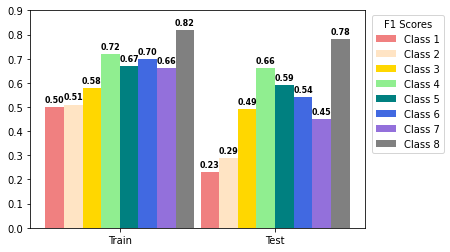

In [28]:
f1_1 =[0.50, 0.23]
f1_2 = [0.51, 0.29]
f1_3 = [0.58, 0.49]
f1_4 = [0.72, 0.66]
f1_5 = [0.67, 0.59]
f1_6 = [0.70, 0.54]
f1_7 = [0.66, 0.45]
f1_8 = [0.82, 0.78]
index = np.arange(2)
sets = ['Train', 'Test']
bar_width = 0.12
score_label = np.arange(0, 1, 0.1)
fig, ax = plt.subplots()
bar1 = ax.bar(index - 3.5*bar_width, f1_1, bar_width, label = 'Class 1', color = 'lightcoral')
bar2 = ax.bar(index - 2.5*bar_width, f1_2, bar_width, label = 'Class 2', color = 'bisque')
bar3 = ax.bar(index - 1.5*bar_width, f1_3, bar_width, label = 'Class 3', color = 'gold')
bar4 = ax.bar(index - 0.5*bar_width, f1_4, bar_width, label = 'Class 4', color = 'lightgreen')
bar5 = ax.bar(index + 0.5*bar_width, f1_5, bar_width, label = 'Class 5', color = 'teal')
bar6 = ax.bar(index + 1.5*bar_width, f1_6, bar_width, label = 'Class 6', color = 'royalblue')
bar7 = ax.bar(index + 2.5*bar_width, f1_7, bar_width, label = 'Class 7', color = 'mediumpurple')
bar8 = ax.bar(index + 3.5*bar_width, f1_8, bar_width, label = 'Class 8', color = 'grey')
ax.set_xticks(index)
ax.set_xticklabels(sets)
ax.set_yticks(score_label)
ax.legend(title = 'F1 Scores', loc = "upper right", bbox_to_anchor = (1.25, 1))

def insert_data_labels(bars):
    for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{:.2f}'.format(bar.get_height()), 
                    xy = (bar.get_x() + bar.get_width()/2, bar_height), 
                    xytext = (0, 3), weight = 'bold', textcoords = 'offset points', 
                    ha = 'center', va = 'bottom').set_fontsize(8)
insert_data_labels(bar1)
insert_data_labels(bar2)
insert_data_labels(bar3)
insert_data_labels(bar4)
insert_data_labels(bar5)
insert_data_labels(bar6)
insert_data_labels(bar7)
insert_data_labels(bar8)

plt.show()